In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import json 

import pprint
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from preprocessor import get_train_environment

# Tune n_estimators & max_depth for XGBClassifier

In [2]:
# Define parameter grid
n_estimators = list(range(10, 100, 10)) + list(range(100, 600, 100))
max_depth = list(range(2, 6, 1))
param_grid = [(n, d) for n in n_estimators for d in max_depth]

# Initialize variables to track the best parameters
best_params = None
best_score = 0
model_performance = []

# Iterate over all combinations of parameters
for n, d in param_grid:
    f1_scores = []
    print(n,d)
    
    # Iterate over folds
    envGen = get_train_environment(n_splits=5)
    stats, X, X_holdout, y, y_holdout = next(envGen)
    
    for fold, stats, X_train, X_test, y_train, y_test in envGen:
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Skipping empty fold: {fold}")
            continue
        class_y_train = [0 if value == 0 else 1 for value in y_train]
        class_y_test = [0 if value == 0 else 1 for value in y_test]
        # Create and fit the model
        model = XGBClassifier(n_estimators=n, max_depth=d)
        model.fit(X_train, class_y_train)

        # Predict and evaluate
        predictions = model.predict(X_test)

        # Check if predictions are valid
        if not np.any(np.isnan(predictions)):
            f1 = f1_score(class_y_test, predictions, average='weighted')
            #print("Mean Squared Error: ", f1)
            f1_scores.append(f1)
            performance = {
                'n_estimators': n,
                'max_depth': d,
                'Fold':fold,
                'f1': f1
            }
            model_performance.append(performance)
        else:
            print(f"Invalid predictions in fold: {fold}")       

    # Average f1 across folds for current parameter combination
    avg_f1 = np.mean(f1_scores)
    # Update best parameters if current combination is better
    if avg_f1 > best_score:
        best_score = avg_f1
        best_params = (n, d)


10 2
Found cached folds, using those
10 3
Found cached folds, using those
10 4
Found cached folds, using those
10 5
Found cached folds, using those
20 2
Found cached folds, using those
20 3
Found cached folds, using those
20 4
Found cached folds, using those
20 5
Found cached folds, using those
30 2
Found cached folds, using those
30 3
Found cached folds, using those
30 4
Found cached folds, using those
30 5
Found cached folds, using those
40 2
Found cached folds, using those
40 3
Found cached folds, using those
40 4
Found cached folds, using those
40 5
Found cached folds, using those
50 2
Found cached folds, using those
50 3
Found cached folds, using those
50 4
Found cached folds, using those
50 5
Found cached folds, using those
60 2
Found cached folds, using those
60 3
Found cached folds, using those
60 4
Found cached folds, using those
60 5
Found cached folds, using those
70 2
Found cached folds, using those
70 3
Found cached folds, using those
70 4
Found cached folds, using those
7

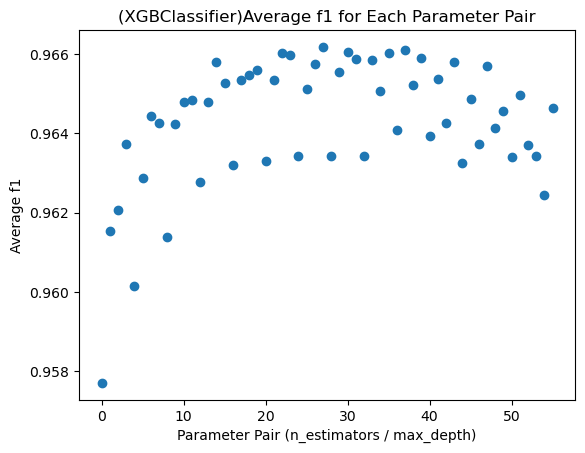

In [3]:
# Aggregate f1 values for each (n_estimators, max_depth) pair
f1_aggregate = {}

for entry in model_performance:
    key = (entry['n_estimators'], entry['max_depth'])
    if key not in f1_aggregate:
        f1_aggregate[key] = []
    f1_aggregate[key].append(entry['f1'])

# Calculate average f1 for each pair
average_f1 = {k: sum(v)/len(v) for k, v in f1_aggregate.items()}

# Prepare data for plotting
n_estimators = [k[0] for k in average_f1.keys()]
max_depth = [k[1] for k in average_f1.keys()]
avg_f1 = list(average_f1.values())

#plt.figure(figsize=(28,9))
plt.scatter(range(len(avg_f1)), avg_f1)
plt.xlabel('Parameter Pair (n_estimators / max_depth)')
plt.ylabel('Average f1')
plt.title('(XGBClassifier)Average f1 for Each Parameter Pair')
plt.show()

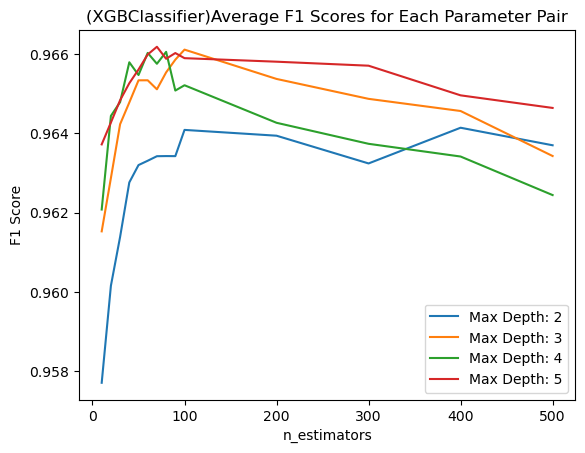

In [4]:
df = pd.DataFrame([{'n_estimators': k[0], 'max_depth': k[1], 'f1_score': v} for k, v in average_f1.items()])

for depth in sorted(df['max_depth'].unique()):
    subset = df[df['max_depth'] == depth]
    plt.plot(subset['n_estimators'], subset['f1_score'], label=f'Max Depth: {depth}')
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')
plt.title('(XGBClassifier)Average F1 Scores for Each Parameter Pair')
plt.legend()
plt.show()

In [5]:

print(f"Best parameters: n_estimators={best_params[0]}, max_depth={best_params[1]} with f1: {best_score}")

Best parameters: n_estimators=70, max_depth=5 with f1: 0.966184399199603


# Compare differernt loss function's f1

In [6]:
# envGen = get_train_environment(n_splits=10)
# results = []
# # The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
# stats, X, X_holdout, y, y_holdout = next(envGen)

# featureNums = range(1, len(X[0]), 10)

# featureNumf1s = {}


# for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
#     f1_scores1 = []
#     f1_scores2 = []
#     print(f"Fold: {fold}")
#     class_y_train_fold = [0 if value == 0 else 1 for value in y_train_fold]
#     class_y_test_fold = [0 if value == 0 else 1 for value in y_test_fold]
    
#     model1 = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1], objective='binary:logistic') #Default
#     model1.fit(X_train_fold, class_y_train_fold)
#     predictions1 = model1.predict(X_test_fold)  
    
#     model2 = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1], objective='binary:hinge')
#     model2.fit(X_train_fold, class_y_train_fold)
#     predictions2 = model2.predict(X_test_fold)

#     f11 = f1_score(class_y_test_fold, predictions1, average='weighted')
#     f12 = f1_score(class_y_test_fold, predictions2, average='weighted')
#     f1_scores1.append(f11)
#     f1_scores2.append(f12)
    
# print(np.mean(f1_scores1))
# print(np.mean(f1_scores2))

# Find important feature

In [7]:
best_params

(70, 5)

In [8]:
envGen = get_train_environment(n_splits=5)
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

# Initialize variables to track important features num
print(len(X[0]))
featureNums = range(1, len(X[0]), 10)
featureNumf1s = {}

# Cross validation folds
for fold, stats, X_train, X_test, y_train, y_test in envGen:
    print(f"Fold: {fold}")
    class_y_train = [0 if value == 0 else 1 for value in y_train]
    class_y_test = [0 if value == 0 else 1 for value in y_test]
    
    model = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1])
    model.fit(X_train, class_y_train)

    # print(model.feature_importances_)
    # make predictions for test data and evaluate
    predictions = model.predict(X_test)
    f1 = f1_score(class_y_test, predictions, average='weighted')
    print("Overall Fold Mean Squared Error: ", f1)
    
    thresholds = enumerate(model.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    eps = 0.000001
    lastf1 = None
    for featureNum in featureNums:
        selectedFeatures = [i for i, x in thresholds[:featureNum]]
        
        model = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1])
        XT = X_train[:, selectedFeatures]
        model.fit(XT, class_y_train)
        
        predictions = model.predict(X_test[:, selectedFeatures])
        f1 = f1_score(class_y_test, predictions, average='weighted')
        
        if lastf1 is not None:
            if np.abs(f1 - lastf1) < eps:
                print(np.abs(f1 - lastf1))
                print(f1)
                break
            else:
                lastf1 = f1
        else:
            lastf1 = f1
        
        if featureNum in featureNumf1s:
            featureNumf1s[featureNum].append(f1)
        else:
            featureNumf1s[featureNum] = [f1]
        
        print(f"FeatureNum: {featureNum}")
        print("FeatureNum Mean Squared Error: ", f1)



Found cached folds, using those
1574
Fold: 0
Overall Fold Mean Squared Error:  0.966411993911615
FeatureNum: 1
FeatureNum Mean Squared Error:  0.9194383570757694
FeatureNum: 11
FeatureNum Mean Squared Error:  0.957192434576936
FeatureNum: 21
FeatureNum Mean Squared Error:  0.9600719438192855
FeatureNum: 31
FeatureNum Mean Squared Error:  0.9652444449478438
FeatureNum: 41
FeatureNum Mean Squared Error:  0.9667749956531464
FeatureNum: 51
FeatureNum Mean Squared Error:  0.9674309703141039
FeatureNum: 61
FeatureNum Mean Squared Error:  0.9652444449478438
FeatureNum: 71
FeatureNum Mean Squared Error:  0.9647870268887012
FeatureNum: 81
FeatureNum Mean Squared Error:  0.9657539476615488
FeatureNum: 91
FeatureNum Mean Squared Error:  0.9636135693903957
FeatureNum: 101
FeatureNum Mean Squared Error:  0.967894325932702
FeatureNum: 111
FeatureNum Mean Squared Error:  0.9669211464712043
FeatureNum: 121
FeatureNum Mean Squared Error:  0.9663138466417565
0.0
0.9663138466417565
Fold: 1
Overall Fold M

In [9]:
avgFeatureNumf1s = {x: np.mean(featureNumf1s[x]) for x in featureNumf1s}
optimal_FeatureNum = [max(avgFeatureNumf1s, key=avgFeatureNumf1s.get),avgFeatureNumf1s[max(avgFeatureNumf1s, key=avgFeatureNumf1s.get)]]
print("Optimal # of features: ",optimal_FeatureNum[0],", f1: ",optimal_FeatureNum[1])

Optimal # of features:  131 , f1:  0.9683101234839409


Text(0.5, 1.0, 'XGBoost Classifier feature number vs f1')

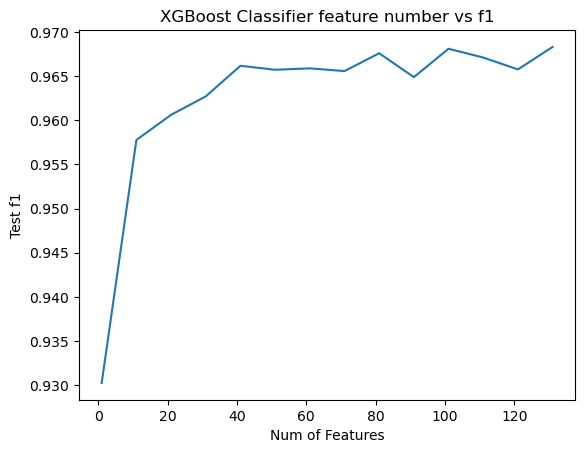

In [10]:
ax = sns.lineplot(pd.Series(avgFeatureNumf1s))
ax.set_xlabel("Num of Features")
ax.set_ylabel("Test f1")
ax.set_title("XGBoost Classifier feature number vs f1")

# Create final model after tuning & select important features

In [11]:
envGen = get_train_environment(n_splits=50)
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

final_f1s = []
final_selection_intersection = set()
allSelecteds = []

# Cross validation folds
for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")
    class_y_train = [0 if value == 0 else 1 for value in y_train_fold]
    class_y_test = [0 if value == 0 else 1 for value in y_test_fold]
    
    model = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1])
    model.fit(X_train_fold, class_y_train)

    print(model.feature_importances_)
    # make predictions for test data and evaluate
    pre_predictions = model.predict(X_test_fold)

    pre_f1 = f1_score(class_y_test, pre_predictions)
    print("Pre Selection f1: ", pre_f1)
    
    thresholds = enumerate(model.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    selectedFeatures = [i for i, x in thresholds[:optimal_FeatureNum[0]]]
    allSelecteds.append(selectedFeatures)
    
    if len(final_selection_intersection) == 0:
        final_selection_intersection = final_selection_intersection.union(selectedFeatures)
    else:
        final_selection_intersection = final_selection_intersection.intersection(selectedFeatures)
    
    model = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1])
    
    XT = X_train_fold[:, selectedFeatures]
    model.fit(XT, class_y_train)

    post_predictions = model.predict(X_test_fold[:, selectedFeatures])
    post_f1 = f1_score(class_y_test, post_predictions)
    print("Post Selection f1: ", post_f1)
    final_f1s.append(post_f1)

Found cached folds, using those
Fold: 0
[0.00535348 0.00940643 0.00226265 ... 0.00566638 0.00290633 0.00320184]
Pre Selection f1:  0.9851632047477744
Post Selection f1:  0.9822485207100591
Fold: 1
[0.00523636 0.00790019 0.00327157 ... 0.00514703 0.00297905 0.00397094]
Pre Selection f1:  0.9813664596273292
Post Selection f1:  0.9813664596273292
Fold: 2
[0.0058346  0.00918008 0.0040715  ... 0.00434744 0.00339073 0.00339801]
Pre Selection f1:  0.9766081871345028
Post Selection f1:  0.9739130434782609
Fold: 3
[0.0052645  0.00795798 0.00460649 ... 0.00608914 0.00349098 0.00282478]
Pre Selection f1:  0.9834983498349835
Post Selection f1:  0.9834983498349835
Fold: 4
[0.00556317 0.00776077 0.00368051 ... 0.00604144 0.00282392 0.00385586]
Pre Selection f1:  0.9817073170731707
Post Selection f1:  0.9817073170731707
Fold: 5
[0.00495799 0.00633217 0.00430627 ... 0.0047566  0.00317453 0.00326046]
Pre Selection f1:  0.9646302250803858
Post Selection f1:  0.9646302250803858
Fold: 6
[0.00580337 0.0088

In [12]:
print(np.mean(final_f1s))

0.9806427952300338


Text(0.5, 1.0, 'Final XGBoost Classifier Model CV Results')

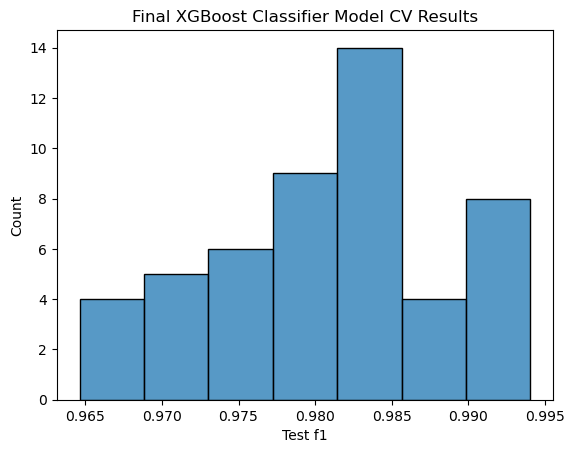

In [13]:
ax = sns.histplot(final_f1s)
ax.set_xlabel("Test f1")
ax.set_title("Final XGBoost Classifier Model CV Results")

In [15]:
print("Num of selected features: ",optimal_FeatureNum[0], "n_estimator:", best_params[0],"max_dapth: ",best_params[1])

Num of selected features:  131 n_estimator: 70 max_dapth:  5


In [16]:
def feature_labels(features):
    data = pd.read_csv("FinalData.csv")
    data = data.drop(["Name", "appid", 'ln.pricep1', "Unnamed: 0"], axis=1)
    data_columns = data.columns.tolist()
    return [x for i, x in enumerate(data_columns) if i in features]

In [17]:
xgb_class_final_features = feature_labels(final_selection_intersection)

In [18]:
xgb_class_final_features

['release_date',
 'Single-player',
 'Online Co-op',
 'Shared/Split Screen Co-op',
 'Steam Achievements',
 'Full controller support',
 'Steam Trading Cards',
 'Captions available',
 'Steam Workshop',
 'Steam Cloud',
 'Includes level editor',
 'Remote Play on TV',
 'tag_Puzzle',
 'genre_Action',
 'genre_Casual',
 'genre_Indie',
 'genre_Simulation',
 'genre_RPG',
 'tag_Multiplayer',
 'tag_Indie',
 'Partial Controller Support',
 'tag_Singleplayer',
 'tag_Strategy',
 'tag_FPS',
 'tag_Shooter',
 'Profile Features Limited',
 'tag_Cute',
 'tag_Memes',
 'tag_Simulation',
 'tag_Open World',
 'genre_Early Access',
 'tag_Card Game',
 'tag_Adventure',
 'tag_Exploration',
 'tag_Visual Novel',
 'tag_Casual',
 'tag_Free to Play',
 'In-App Purchases',
 'tag_Tower Defense',
 'tag_Survival Horror',
 'tag_Third-Person Shooter',
 'tag_Building',
 'tag_Realistic',
 'tag_Psychological Horror',
 'tag_Lovecraftian',
 'tag_Arcade',
 'tag_Online Co-Op',
 'tag_Clicker',
 'tag_Idler',
 'tag_Military',
 'tag_Turn-B